In [139]:
#Install librosa package
!pip install librosa --user

In [140]:
#Run this cell to set up imports

from IPython.display import display, Math
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import librosa
from statsmodels.tsa.seasonal import seasonal_decompose

# STAT 153: Time Series Homework Two
## Due Date: Monday, February 24th, 11:59 P.M.

# Scoring Breakdown (Undergraduate)
|Question|Points|
|---|---|
|1a|2|
|1b|4|
|1c|2|
|1d|1|
|2a|3|
|2b|4|
|2c|6|
|2d|2|
|3a|4|
|3b|2|
|3c|2|
|4|5|
|5a|6|
|5b|2|
|5c|4|
|6a|4|
|6b|5|
|6c|2|
|7a|4|
|7b|2|
|**Total**|70|

In [141]:
# Load the MP3 file
y, sr = librosa.load("AudioNote.mp3", sr=None)
n = len(y)
print(n)
print(f"Sample Rate: {sr} Hz")
print(f"Duration: {n / sr} seconds")

885249
Sample Rate: 44100 Hz
Duration: 20.073673469387757 seconds


## Question 1a) 

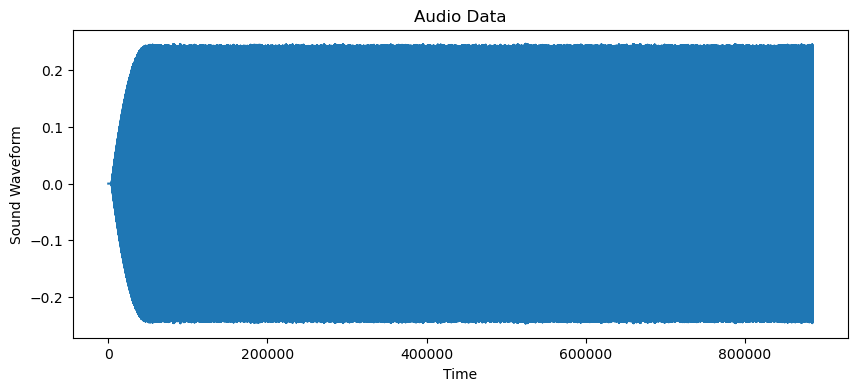

In [142]:
plt.figure(figsize=(10, 4))
plt.plot(y)
plt.title("Audio Data")
plt.xlabel("Time")
plt.ylabel("Sound Waveform")
plt.show()

## Interpretation

The plot shows a consistent amplitude, indicating a sustained note without significant variation in loudness. The waveform of the audio signal shows a continuous and sustained oscillation, indicating a steady musical note. Given the high and uniform frequency, the note is likely a pure tone with minimal harmonic variations. The amplitude remains fairly constant throughout, suggesting the note is played at a consistent volume.

## Questions 1b & 1c

Text(0, 0.5, 'Sound waveform')

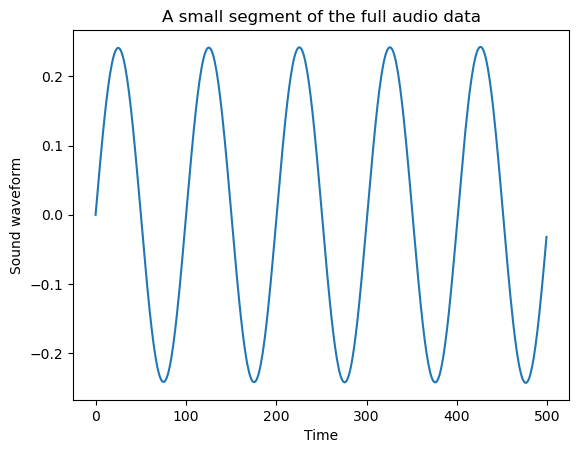

In [143]:
y_smallpart = y[50000:(50000 + 500)]
plt.plot(y_smallpart)
plt.xlabel('Time')
plt.title('A small segment of the full audio data')
plt.ylabel('Sound waveform')

In [144]:
def periodogram(y):
    fft_y = np.fft.fft(y)
    n = len(y)
    fourier_freqs = np.arange(1/n, 1/2, 1/n)
    m = len(fourier_freqs)
    pgram_y = (np.abs(fft_y[1:m+1]) ** 2)/n
    return fourier_freqs, pgram_y

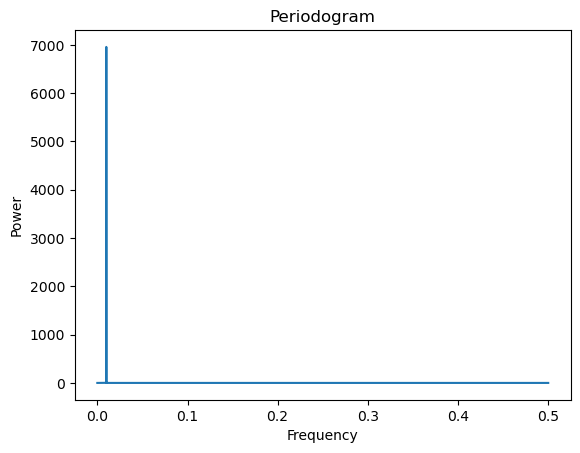

In [145]:
freqs, pgram = periodogram(y)
plt.plot(freqs, pgram)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Periodogram')
plt.show()

In [146]:
def rss_periodogram(y):
    fft_y = np.fft.fft(y)
    n = len(y)
    fourier_freqs = np.arange(1/n, 1/2, 1/n)
    m = len(fourier_freqs)
    pgram_y = (np.abs(fft_y[1:m+1]) ** 2)/n
    var_y = np.sum((y - np.mean(y)) ** 2)
    rssvals = var_y - 2*pgram_y
    return fourier_freqs, rssvals

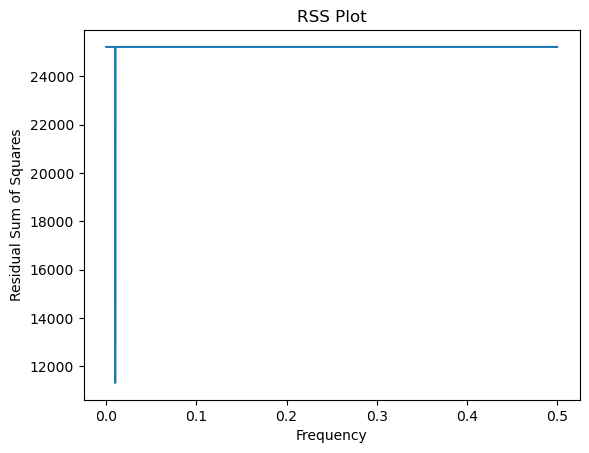

In [147]:
freqs, rssvals = rss_periodogram(y)
plt.plot(freqs, rssvals)
plt.xlabel('Frequency')
plt.ylabel('Residual Sum of Squares')
plt.title('RSS Plot')
plt.show()

In [148]:
#Now we estimate the frequency parameter f in the single sinusoidal model: 
fhat = freqs[np.argmax(pgram)]
print(fhat)
#To get the frequency in Hertz (which is the number of cycles in one sec)
print(fhat * sr)

0.009976853969899993
439.9792600725897


In [149]:
#Uncertainty quantification for f: 
def logpost_periodogram(y):
    fft_y = np.fft.fft(y)
    n = len(y)
    fourier_freqs = np.arange(1/n, (1/2) + (1/n), 1/n)
    m = len(fourier_freqs)
    pgram_y = (np.abs(fft_y[1:m+1]) ** 2)/n
    var_y = np.sum((y - np.mean(y)) ** 2)
    rssvals = var_y - 2*pgram_y
    p = 3
    logpostvals = ((p-n)/2) * np.log(rssvals)
    return fourier_freqs, logpostvals

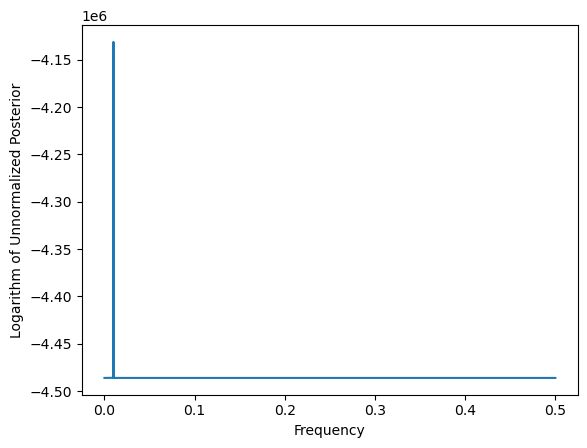

In [150]:
freqs, logpostvals = logpost_periodogram(y)
plt.plot(freqs, logpostvals)
plt.xlabel('Frequency')
plt.ylabel('Logarithm of Unnormalized Posterior')
plt.show()

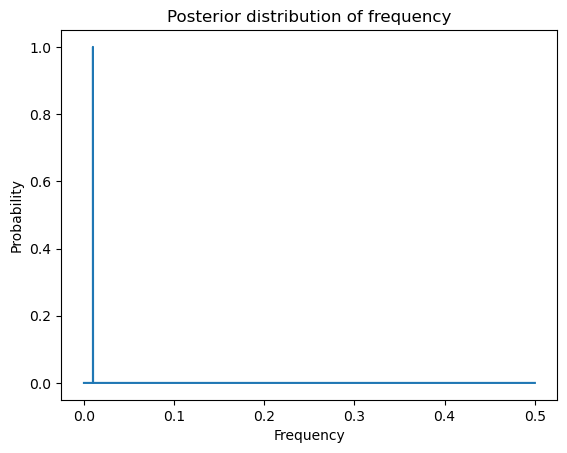

In [151]:
postvals_unnormalized = np.exp(logpostvals - np.max(logpostvals))
postvals = postvals_unnormalized/(np.sum(postvals_unnormalized))
plt.plot(freqs, postvals)
plt.xlabel('Frequency')
plt.ylabel('Probability')
plt.title('Posterior distribution of frequency')
plt.show()

In [152]:
def PostProbAroundMax(m):
    est_ind = np.argmax(postvals)
    ans = np.sum(postvals[(est_ind-m):(est_ind+m)])
    return(ans)
m = 0
while PostProbAroundMax(m) <= 0.95:
    m = m+1
est_ind = np.argmax(postvals)
f_est = freqs[est_ind]
#95% credible interval for f:
ci_f_low = freqs[est_ind - m]
ci_f_high = freqs[est_ind + m]
print("Uncertainty interval for f:", np.array([f_est, ci_f_low, ci_f_high]))
#Uncertainty estimate in Hertz:
f_est_hz = f_est * sr
ci_f_low_hz = ci_f_low * sr
ci_f_high_hz = ci_f_high * sr
print(np.array([f_est_hz, ci_f_low_hz, ci_f_high_hz]))

Uncertainty interval for f: [0.00997685 0.00997572 0.00997798]
[439.97926007 439.92944358 440.02907656]


### Solution:

1b) As reflected above the best point estimate for $f$ is: **0.00997** with a 95% uncertainty interval of **[0.00997572, 0.00997798]**

1c) The best estimate of the frequency of the music note generated in the sound file in Hertz is: **440.03**

## Question 1d)

Given the frequency of 440 Hz we can assume the note is A4, which is the standard pitch for tuning musical instruments, and is also known as the concert pitch 

## Question 2a)

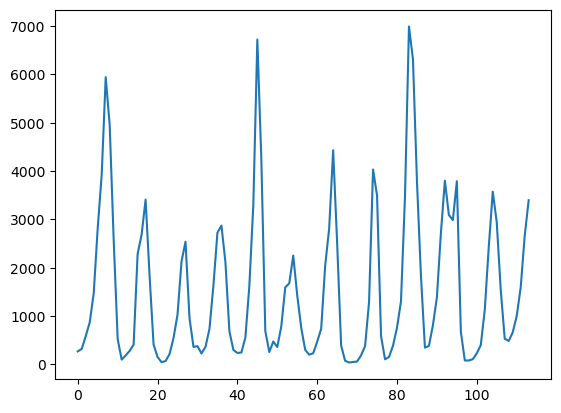

In [153]:
lynx = pd.read_csv("lynx.csv")
y = lynx["count"].values
plt.plot(y)
plt.show()

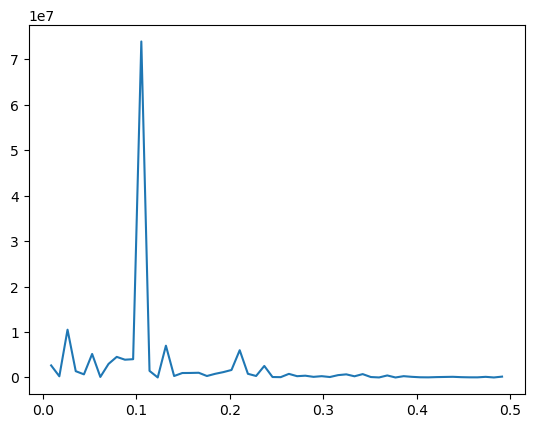

In [154]:
freqs, pgram = periodogram(y)
plt.plot(freqs, pgram)
plt.show()

#### Observations

There are a couple of peaks in the periodogram. The most dominant peak is around 0.1 cycles per year, which suggest a periodicity of 10 years. Beyond 0.3 cycles per year, the power spectrum flattens, suggesting that shorter cycles (~less than 3 years) are not dominant in this dataset. 

## Question 2b)

In [155]:
fhat = freqs[np.argmax(pgram)]
period_hat = 1/fhat
print(fhat)
print(period_hat)

0.10526315789473684
9.5


In [156]:
freqs, logpostvals = logpost_periodogram(y)
postvals_unnormalized = np.exp(logpostvals - np.max(logpostvals))
postvals = postvals_unnormalized/(np.sum(postvals_unnormalized))

def PostProbAroundMax(m):
    est_ind = np.argmax(postvals)
    ans = np.sum(postvals[(est_ind-m):(est_ind+m)])
    return(ans)
m = 0
while PostProbAroundMax(m) <= 0.95:
    m = m+1
est_ind = np.argmax(postvals)
f_est = freqs[est_ind]
#95% credible interval for f:
ci_f_low = freqs[est_ind - m]
ci_f_high = freqs[est_ind + m]
print(np.array([f_est, ci_f_low, ci_f_high]))

period_est = 1/f_est
ci_period_low = 1/ci_f_high
ci_period_high = 1/ci_f_low
print(np.array([ci_period_low, period_est, ci_period_high]))

[0.10526316 0.09649123 0.11403509]
[ 8.76923077  9.5        10.36363636]


In [157]:
def logpost(f):
    n = len(y)
    x = np.arange(1, n+1)
    xcos = np.cos(2 * np.pi * f * x)
    xsin = np.sin(2 * np.pi * f * x)
    X = np.column_stack([np.ones(n), xcos, xsin])
    p = X.shape[1]
    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)
    sgn, log_det = np.linalg.slogdet(np.dot(X.T, X)) #sgn gives the sign of the determinant (in our case, this should 1)
    #log_det gives the logarithm of the absolute value of the determinant
    logval = ((p-n)/2) * np.log(rss) - (0.5)*log_det
    return logval

allfvals = np.arange(0.01, 0.5, .0001) #much finer grid
logpostvals = np.array([logpost(f) for f in allfvals])
postvals = np.exp(logpostvals - np.max(logpostvals))
postvals = postvals/(np.sum(postvals))
print(allfvals[np.argmax(postvals)])
print(1/allfvals[np.argmax(postvals)])


0.10379999999999943
9.633911368015466


In [158]:
def PostProbAroundMax(m):
    est_ind = np.argmax(postvals)
    ans = np.sum(postvals[(est_ind-m):(est_ind+m)])
    return(ans)
m = 0
while PostProbAroundMax(m) <= 0.95:
    m = m+1
est_ind = np.argmax(postvals)
f_est = allfvals[est_ind]
#95% credible interval for f:
ci_f_low = allfvals[est_ind - m]
ci_f_high = allfvals[est_ind + m]
print(np.array([f_est, ci_f_low, ci_f_high]))

period_est = 1/f_est
ci_period_low = 1/ci_f_high
ci_period_high = 1/ci_f_low
print(np.array([ci_period_low, period_est, ci_period_high]))

[0.1038 0.1029 0.1047]
[9.55109838 9.63391137 9.71817298]


#### Conclusion

Based on the results from the lynx trappings dataset. The point estimated frequency is 0.0138 cycles per year corresponding, to a period of 9.63 years. For the 95% credible interval the frequency is in the range [0.1029, 0.1047] cycles per year, giving a period range of [9.55, 9.71] years.

## Question 2c

In [159]:
import statsmodels.api as sm
import numpy as np
from scipy.stats import chi2 

n = len(y)
t = np.arange(1, n+1)
f_est = 0.10379999999999943   # Use your estimated frequency

# Design matrix
X = np.column_stack([np.ones(n), np.cos(2 * np.pi * f_est * t), np.sin(2 * np.pi * f_est * t)])

# Fit OLS model
model = sm.OLS(y, X).fit()

# Extract estimates
beta0, beta1, beta2 = model.params
sigma = np.sqrt(model.scale)  # Standard deviation of residuals

# Extract 95% confidence intervals
ci_beta0, ci_beta1, ci_beta2 = model.conf_int(alpha=0.05)

alpha = 0.05  # 95% confidence level
df = n - X.shape[1]  # Degrees of freedom (n - number of estimated parameters)

chi2_low = chi2.ppf(alpha / 2, df)
chi2_high = chi2.ppf(1 - alpha / 2, df)

ci_sigma = [sigma * np.sqrt(df / chi2_high), sigma * np.sqrt(df / chi2_low)]

In [160]:
print("Beta estimates, beta0:", beta0,"beta1:", beta1,"beta2", beta2)
print("95% Certainty intervals: beta0", ci_beta0,"beta1", ci_beta1,"beta2", ci_beta2)
print("95% Certainty inverval for Sigma:", ci_sigma[0],ci_sigma[1])
print("Sigma estimate",sigma)

Beta estimates, beta0: 1547.82669090766 beta1: 404.2178867322483 beta2 -1625.4265668498308
95% Certainty intervals: beta0 [1352.41155014 1743.24183167] beta1 [126.24736357 682.18840989] beta2 [-1900.15547995 -1350.69765375]
95% Certainty inverval for Sigma: 930.598384705098 1212.0687568924345
Sigma estimate 1052.7357015675902


#### Conclusion

$\beta_0$(Intercept): 1547.83 with a 95% confidence interval of [1352.41, 1743.24].

$\beta_1$(Cosine term coefficient): 404.22 with a 95% confidence interval of [126.25, 682.19].

$\beta_2$(Sine term coefficient): -1625.43 with a 95% confidence interval of [-1900.16, -1350.70].

The estimated residual standard deviation $(\sigma)$ is 1052.74, with a 95% confidence interval of [930.60, 1212.07].

## Question 2d

The given model is a simple sinusoidal regression model designed to capture periodic trends in the dataset. The model does provide useful insights, particularly in identifying a dominant periodicity of approximately 9.63 years. The statistical significance of $\beta_0$ and $beta_1$ suggest that the sinusoidal terms contribute meaningfully to explaining the variance in the data. However, the residual standard deviation $(\sigma)$ is relatively large, indicating substantial unexplained variability. While the model provides a reasonable first approximation of the dataset's periodicity, it may not fully capture all variations in the data. A more complex model incorporating multiple frequencies time-varying amplitudes, or external covariates might yield a better fit.

## Question 3a

In [161]:
# Load the dataset
mask = pd.read_csv("mask_data.csv")

# Drop the first row (which contains misplaced column headers)
mask = mask.iloc[1:].reset_index(drop=False)

# Rename columns for clarity
mask.columns = ["Month", "Search_Popularity"]

# Convert "Month" column to datetime format
mask["Month"] = pd.to_datetime(mask["Month"])
mask["Search_Popularity"] = pd.to_numeric(mask["Search_Popularity"])

# Check the data
mask

,Month,Search_Popularity
0,2004-01-01,4
1,2004-02-01,4
2,2004-03-01,4
3,2004-04-01,4
4,2004-05-01,4
...,...,...
249,2024-10-01,15
250,2024-11-01,12
251,2024-12-01,14
252,2025-01-01,13


In [162]:
# Extract the search popularity values as y
y = mask["Search_Popularity"].values 
# Generate time index (t) based on the data's timeline
t = np.arange(1, len(y) + 1) 
n= len(y)

In [163]:
def rss(c):
    x = np.arange(1, n + 1)
    xc = (x > c).astype(float)
    X = np.column_stack([np.ones(n), xc])

    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)

    return rss

In [164]:
allcvals = np.arange(5, n - 4) 
# we are ignoring a few points at the beginning and at the end
rssvals = np.array([rss(c) for c in allcvals])


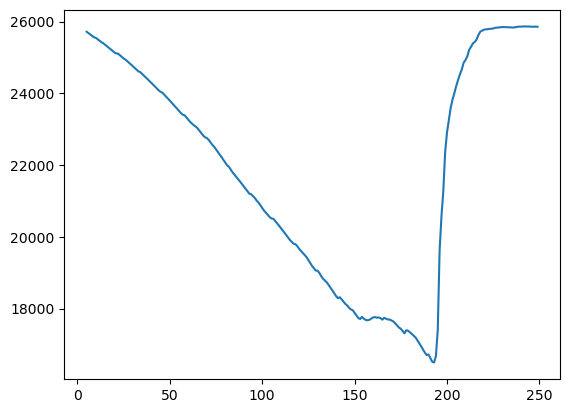

In [165]:
plt.plot(allcvals, rssvals)
plt.show()

In [166]:
c_hat = allcvals[np.argmin(rssvals)]
print(c_hat)

193


In [167]:
def logpost(c):
    x = np.arange(1, n+1)
    xc = (x > c).astype(float)
    X = np.column_stack([np.ones(n), xc])
    p = X.shape[1]

    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)
    sgn, log_det = np.linalg.slogdet(np.dot(X.T, X)) 
    # sgn gives the sign of the determinant (in our case, this should 1)
    # log_det gives the logarithm of the absolute value of the determinant
    
    logval = ((p - n) / 2) * np.log(rss) - 0.5 * log_det
    return logval

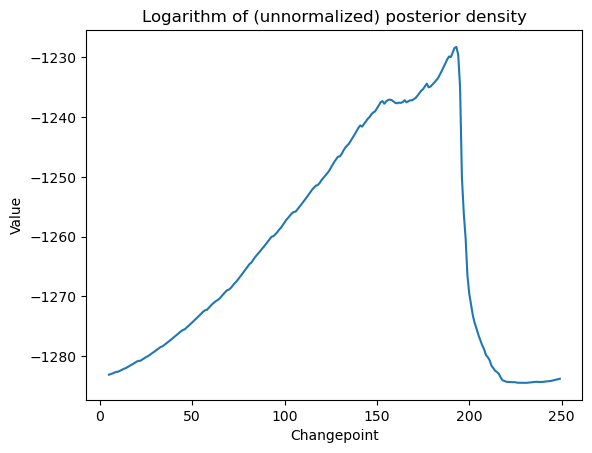

In [168]:
allcvals = np.arange(5, n - 4)
logpostvals = np.array([logpost(c) for c in allcvals])

plt.plot(allcvals, logpostvals)
plt.xlabel('Changepoint')
plt.ylabel('Value')
plt.title('Logarithm of (unnormalized) posterior density')
plt.show() 
# this plot looks similar to the RSS plot

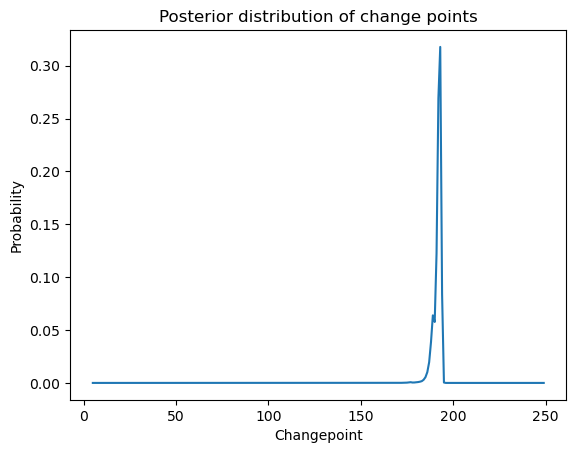

In [169]:
postvals_unnormalized = np.exp(logpostvals - np.max(logpostvals))
postvals = postvals_unnormalized / (np.sum(postvals_unnormalized))

plt.plot(allcvals, postvals)
plt.xlabel('Changepoint')
plt.ylabel('Probability')
plt.title('Posterior distribution of change points')
plt.show()

In [170]:
# Compute the cumulative sum of posterior probabilities
cdf = np.cumsum(postvals)

# Find indices corresponding to 2.5% and 97.5% probability mass
lower_idx = np.searchsorted(cdf, 0.025)
upper_idx = np.searchsorted(cdf, 0.975)

# Extract the 95% credible interval for c
c_lower = allcvals[lower_idx]
c_upper = allcvals[upper_idx]

print(f"95% Credible Interval for c: [{c_lower}, {c_upper}]")

95% Credible Interval for c: [186, 194]


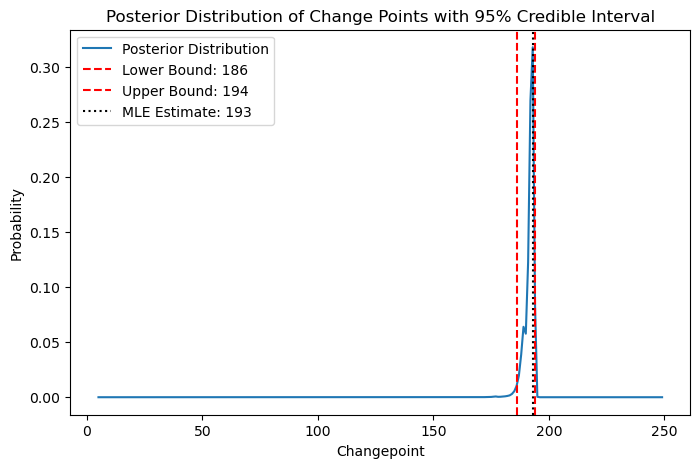

In [171]:
plt.figure(figsize=(8,5))
plt.plot(allcvals, postvals, label="Posterior Distribution")
plt.axvline(c_lower, color='red', linestyle="--", label=f"Lower Bound: {c_lower}")
plt.axvline(c_upper, color='red', linestyle="--", label=f"Upper Bound: {c_upper}")
plt.axvline(c_hat, color='black', linestyle=":", label=f"MLE Estimate: {c_hat}")

plt.xlabel("Changepoint")
plt.ylabel("Probability")
plt.title("Posterior Distribution of Change Points with 95% Credible Interval")
plt.legend()
plt.show()


#### Conclusion

The 95% credible interval for the changepoint interval $c$ is [186, 194], and the MLE estimate for $c$ is 193. Now, to the question of whether these results make sense with reality. Looking at the search popularity data, there is a clear upward shift in search activity around index 193. Given, the time index is monthly from 2004, then: 193 months from 2004 is approximately 2020.1 or early 2020. Also, the narrow width of [186, 194] indicates high confidence in the changepoint's location. This suggests a sharp and well-defined shift, which aligns with the sudden surge in search volume rather than a gradual increase. This aligns well with external events, such as the pandemic's onset, where "mask" searches surged in early 2020. 

## Question 3b

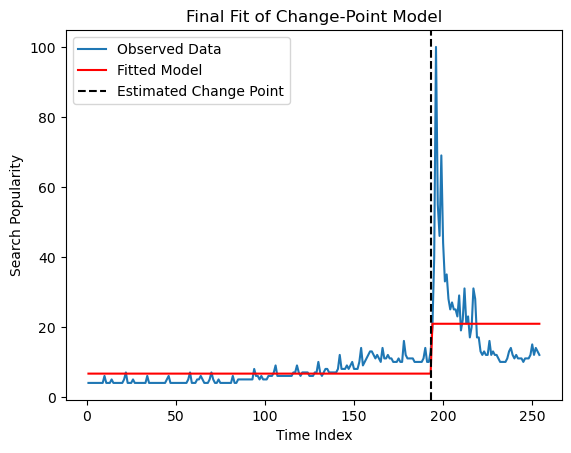

In [172]:
# Plot observed data
plt.plot(t, y, label="Observed Data")

# Plot fitted values using the optimized change point
xc_hat = (t > c_hat).astype(float)
X_hat = np.column_stack([np.ones(len(t)), xc_hat])
model_hat = sm.OLS(y, X_hat).fit()
plt.plot(t, model_hat.fittedvalues, color="red", label="Fitted Model")

# Mark estimated change-point
plt.axvline(x=c_hat, color="black", linestyle="--", label="Estimated Change Point")

# Labels and title
plt.xlabel("Time Index")
plt.ylabel("Search Popularity")
plt.title("Final Fit of Change-Point Model")
plt.legend()
plt.show()

In [173]:
def logpost(c):
    x = np.arange(1, n+1)
    xc = (x > c).astype(float)
    X = np.column_stack([np.ones(n), xc])
    p = X.shape[1]

    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)
    sgn, log_det = np.linalg.slogdet(np.dot(X.T, X)) 
    # sgn gives the sign of the determinant (in our case, this should 1)
    # log_det gives the logarithm of the absolute value of the determinant
    
    logval = ((p - n) / 2) * np.log(rss) - 0.5 * log_det
    return logval

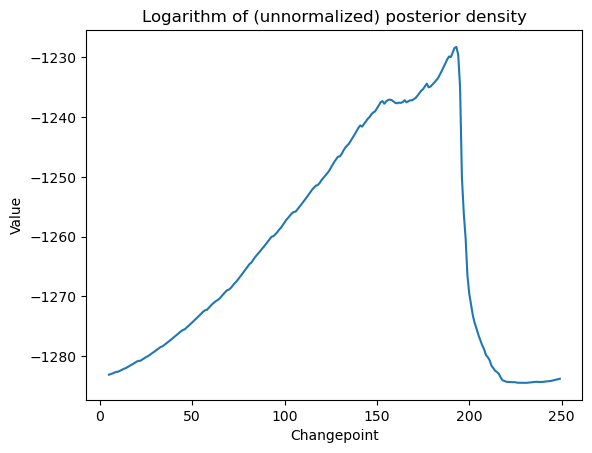

In [174]:
allcvals = np.arange(5, n - 4)
logpostvals = np.array([logpost(c) for c in allcvals])

plt.plot(allcvals, logpostvals)
plt.xlabel('Changepoint')
plt.ylabel('Value')
plt.title('Logarithm of (unnormalized) posterior density')
plt.show() 
# this plot looks similar to the RSS plot

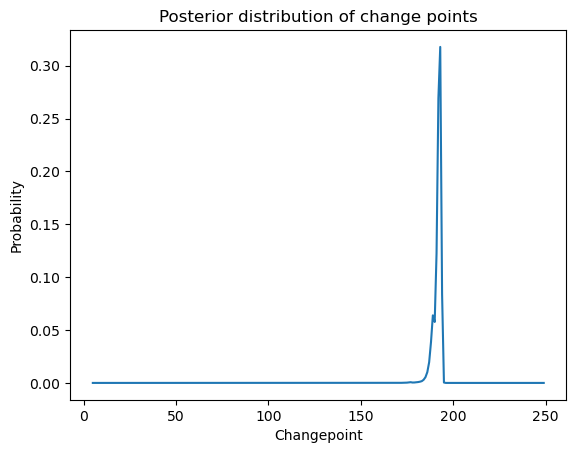

In [175]:
postvals_unnormalized = np.exp(logpostvals - np.max(logpostvals))
postvals = postvals_unnormalized / (np.sum(postvals_unnormalized))

plt.plot(allcvals, postvals)
plt.xlabel('Changepoint')
plt.ylabel('Probability')
plt.title('Posterior distribution of change points')
plt.show()

In [176]:
N = 1000
rng = np.random.default_rng(seed = 42)
cpostsamples = rng.choice(allcvals, N, replace = True, p = postvals)

post_samples = np.zeros(shape = (N, 4))
post_samples[:, 0] = cpostsamples
for i in range(N):
    c = cpostsamples[i]
    x = np.arange(1, n + 1)
    xc = (x > c).astype(float)
    X = np.column_stack([np.ones(n), xc])
    p = X.shape[1]

    md_c = sm.OLS(y, X).fit()

    chirv = rng.chisquare(df = n - p)
    sig_sample = np.sqrt(np.sum(md_c.resid ** 2) / chirv) # posterior sample from sigma
    post_samples[i, (p + 1)] = sig_sample

    covmat = (sig_sample ** 2) * np.linalg.inv(np.dot(X.T, X))
    beta_sample = rng.multivariate_normal(mean = md_c.params, cov = covmat, size = 1)
    post_samples[i, 1:(p + 1)] = beta_sample

print(post_samples)

[[193.           6.50769599  14.24593829   8.37848969]
 [192.           5.93668099  14.738532     8.14637149]
 [193.           6.10464437  13.52946903   8.49421527]
 ...
 [177.           6.63225909  11.96576183   8.1051981 ]
 [194.           7.26707434  13.01324448   8.79299158]
 [191.           6.80232444  13.06347124   8.32595852]]


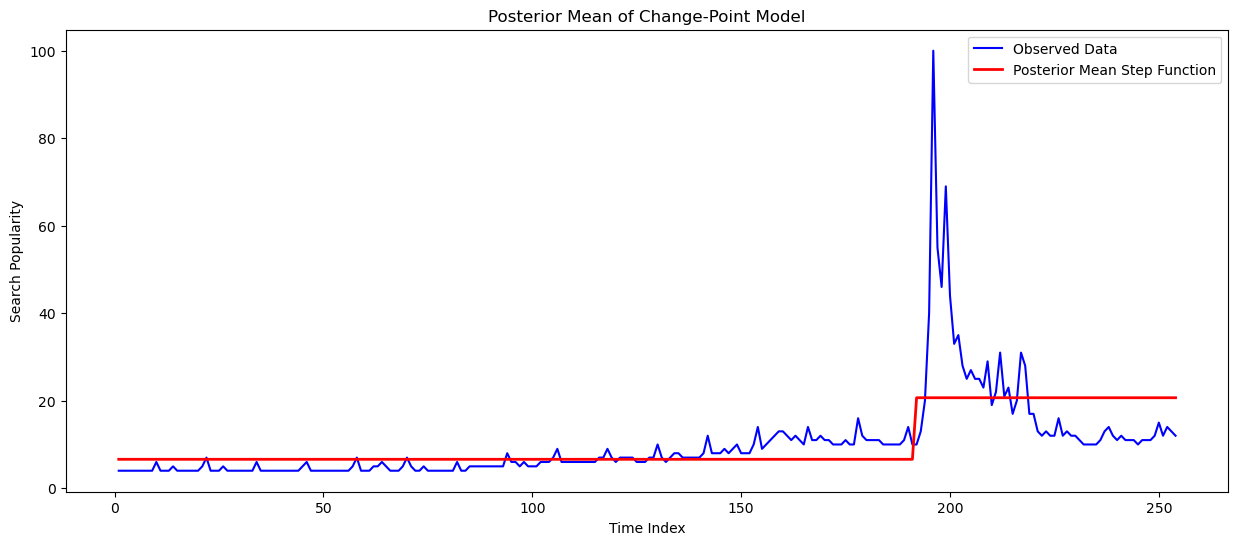

In [177]:
# Compute the mean estimates from the posterior samples
mean_c = np.mean(cpostsamples)
mean_b0 = np.mean(post_samples[:, 1])
mean_b1 = np.mean(post_samples[:, 2])

# Generate the step function based on mean estimates
ftdval_mean = mean_b0 + mean_b1 * (t > mean_c).astype(float)

# Plot observed data
plt.figure(figsize=(15, 6))
plt.plot(t, y, label="Observed Data", color="blue")

# Plot the function using mean estimates
plt.plot(t, ftdval_mean, color="red", linewidth=2, label="Posterior Mean Step Function")

# Labels and legend
plt.xlabel("Time Index")
plt.ylabel("Search Popularity")
plt.title("Posterior Mean of Change-Point Model")
plt.legend()
plt.show()

## Question 3c

There are strengths and weaknesses to the model. The model successfully captures the sharp increase in search popularity at the estimated change-point. The posterior function aligns well with the data before and after the change confirming a clear structural shift. However, the step function assumption oversimplifies the transitio, assuming an abrubt shift rather than a gradual increase. The model fails to capture post-change fluctuations, especially the peak and decline after the initial surge. Thus, the model provides a useful approximation but does not fully capture the complexity of real-world trends

## Question 4 

By observing the time series plots, dataset one has more spaced-out oscillations, meaning the changes occur over longer time periods. Whereas the second dataset has much tighter oscillations, indicating more rapid flutuations. Now, periodogram b shows stronger low-frequency components, meaning it corresponds to a dataset with longer cycles and periodogram has more activity in the high-frequency range, meaning it corresponds to a dataset with shorter, rapid fluctuations. So, in conclusion dataset one corresponds to periodogram b and dataset two corresponds to periodogram a.

## Question 5a

The DFT of the full dataset is $y_0, y_1,...,y_{n-1} is defined as:

$$b_j = \sum^{n-1}_{t=0} y_t \, \text{exp} \left(-2\pi i \frac{jt}{n} \right), \quad j= 0,1,..., n-1$$

We also know that the DFT of one cycle $y_0, y_1,...,y_{h-1}$ is given as:

$$\beta_m = \sum^{h-1}_{t=0} yt \, \text{exp} \left(-2 \pi \frac{mt}{h} \right), \quad m=0, 1,..., h-1$$

Since our data repeats every h, we can rewrite the DFT sum over each cycle separately:
$$b_j = \sum_{t=0}^{n-1} y_t \, \text{exp} \left( -2 \pi i \frac{jt}{n} \right)$$

Rewriting the index $t$ as $t = uh + v$, where:
$$u = 0,1,...,k -1 \quad \text{indexes the cycle number}$$ 
$$v= 0,1,...,h-1 \quad \text{indexes positions wthin one cycle}$$

We rewrite the sum as:
$$b_j = \sum^{k-1}_{u=0} \sum^{h-1}_{v=0} y_v \text{exp} \left(-2 \pi i \frac{j(uh + v)}{n} \right)$$

We can distribute the sigmas by separability of exponentials, this expands to:
$$b_j = \sum^{h-1}_{v=0} y_v \text{exp} \left(-2 \pi i \frac{jv}{n} \right) \sum^{k-1}_{u=0} \text{exp} \left(-2 \pi i \frac{juh}{n} \right)$$

The inner sum is: 
$$\sum^{k-1}_{u=0} \text{exp} \left(-2 \pi i \frac{juh}{n} \right)$$ 
Recall: $n = kh$. Substitute:
$$\sum^{k-1}_{u=0} \text{exp} \left(-2 \pi i \frac{ju}{k} \right)$$


Note: the sum behaves differently depending on whether $j$ is a multiple of $k$. Thus, there are two case:

When $j$ is a multiple of of $k$, say $j=mk$, then:
$$\sum^{k-1}_{u=0} \text{exp} \left(-2 \pi i \frac{mu}{k} \right) = k$$

When $j$ is NOT a multiple of $k$, then the sum is zero because the exponents evenly distribute around the unit circle and sum to zero.

For value where $j=mk$, we are left with: 
$$b_{mk} = k \sum^{h-1}_{v=0} y_v \text{exp} \left(-2 \pi i \frac{mv}{h} \right)$$ 

Note: This summation is the exact definition of $\beta_m$ from the DFT of the base cycle. Thus:

$$b_{mk} = k \beta_{m}, \quad \text{for} \, m = 0, 1, ..., h-1$$.

For all other $j$, we have $b_j = 0$

## Question 5b

In [178]:
# Load the dataset
halloween = pd.read_csv("hallloween_data.csv")

# Drop the first row (which contains misplaced column headers)
halloween = halloween.iloc[1:-2].reset_index(drop=False)

# Rename columns for clarity
halloween.columns = ["Month", "Search_Popularity"]

# Convert "Month" column to datetime format
halloween["Month"] = pd.to_datetime(halloween["Month"])
halloween["Search_Popularity"] = pd.to_numeric(halloween["Search_Popularity"])

y = halloween["Search_Popularity"].values

# Check the data
halloween

,Month,Search_Popularity
0,2004-01-01,1
1,2004-02-01,1
2,2004-03-01,1
3,2004-04-01,1
4,2004-05-01,1
...,...,...
247,2024-08-01,15
248,2024-09-01,31
249,2024-10-01,80
250,2024-11-01,11


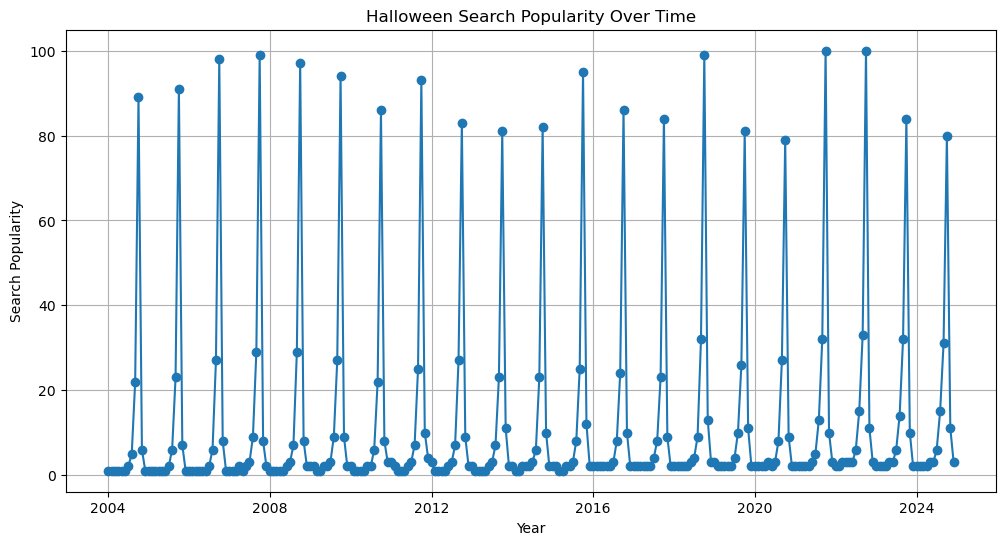

In [179]:
# Plot the data
plt.figure(figsize=(12,6))
plt.plot(halloween["Month"], halloween["Search_Popularity"], marker='o', linestyle='-')
plt.xlabel("Year")
plt.ylabel("Search Popularity")
plt.title("Halloween Search Popularity Over Time")
plt.grid(True)
plt.show()

#### Interpretation

The data exhibits clear annual periodicity, where search interest spikes sharply each year around October. This confirms that intereset in "Halloween" follows a strict seasonal pattern once a year and declining sharply afterward. The amplitude (height) of the spikes remains relatively constant over the years, meaning the general interest in Halloween has remained stable. In conclusion, the dataset is best described as highly seasonal, periodic, and stable, with sharp peaks in October every year.

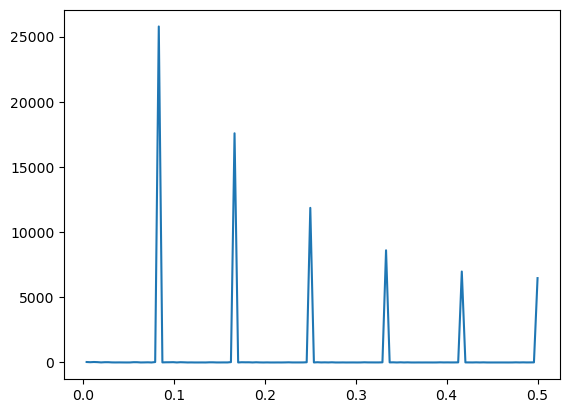

In [180]:
freqs, pgram = periodogram(y)
plt.plot(freqs, pgram)
plt.show()

## Question 5c

#### Connection to DFT Equation

From the proof we showed that when data is periodic with period $h$, the DFT cofficients  (which form the periodogram) are concentrated at integer multiples of $\frac{1}{h}$ and all other frequencies should be zero. In the halloween query the dataset is strictly periodic with period $h=12$. The DFT should thus have nonzero values at multiples of $\frac{1}{12}$, while all other frequencies should ideally be close to zero. We observe this same pattern in the periodogram where there is a strong at $f=12$, which verifies that the main repeating pattern in the data is indeed yearly. Thus, the DFT proof correctly predicted that spectral energy would be concentrated in integer multiples of the fundamental frequency.

## Question 6a

In [181]:
# Load the dataset
golf = pd.read_csv("golf_data.csv")

# Drop the first row (which contains misplaced column headers)
golf = golf.iloc[1:].reset_index(drop=False)

# Rename columns for clarity
golf.columns = ["Month", "Search_Popularity"]

# Convert "Month" column to datetime format
golf["Month"] = pd.to_datetime(golf["Month"])
golf["Search_Popularity"] = pd.to_numeric(golf["Search_Popularity"])

y = golf["Search_Popularity"].values

# Check the data
golf

,Month,Search_Popularity
0,2004-01-01,45
1,2004-02-01,51
2,2004-03-01,65
3,2004-04-01,77
4,2004-05-01,81
...,...,...
249,2024-10-01,41
250,2024-11-01,36
251,2024-12-01,38
252,2025-01-01,35


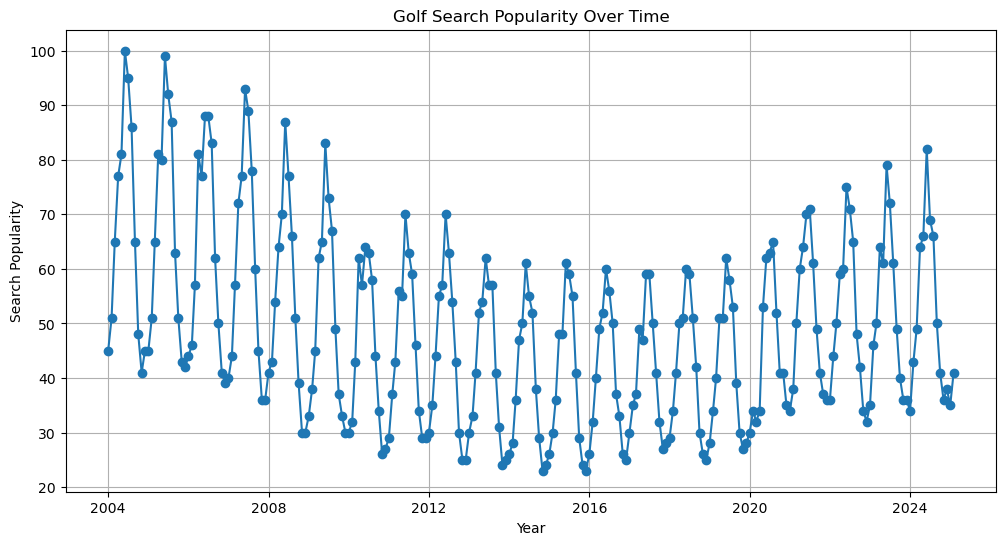

In [182]:
# Plot the data
plt.figure(figsize=(12,6))
plt.plot(golf["Month"], golf["Search_Popularity"], marker='o', linestyle='-')
plt.xlabel("Year")
plt.ylabel("Search Popularity")
plt.title("Golf Search Popularity Over Time")
plt.grid(True)
plt.show()

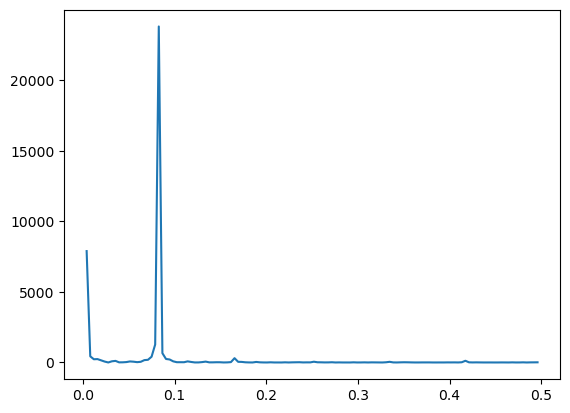

In [183]:
freqs, pgram = periodogram(y)
plt.plot(freqs, pgram)
plt.show()

In [184]:
def logpost(f):
    n = len(y)
    x = np.arange(1, n + 1)  # Time index
    
    # Basis functions: quadratic trend + seasonality
    xcos = np.cos(2 * np.pi * f * x)
    xsin = np.sin(2 * np.pi * f * x)
    xt = x  # Linear trend
    xt2 = x ** 2  # Quadratic trend

    # Design matrix including quadratic trend and seasonal terms
    X = np.column_stack([np.ones(n), xt, xt2, xcos, xsin])
    p = X.shape[1]  # Number of parameters

    # Fit OLS model
    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)  # Residual Sum of Squares

    # Log-determinant penalty for complexity
    sgn, log_det = np.linalg.slogdet(np.dot(X.T, X))

    # Compute log-posterior probability
    logval = ((p - n) / 2) * np.log(rss) - (0.5) * log_det
    return logval

# Define frequency grid for search
allfvals = np.arange(0.01, 0.5, 0.0001)  # Fine search grid

# Compute log-posterior for each frequency
logpostvals = np.array([logpost(f) for f in allfvals])

# Convert log-posterior to probabilities
postvals = np.exp(logpostvals - np.max(logpostvals))
postvals = postvals / np.sum(postvals)  # Normalize

# Find the most probable frequency and its corresponding period
best_f = allfvals[np.argmax(postvals)]
best_period = 1 / best_f

print("Most likely frequency:", best_f)
print("Most likely period (in months):", best_period)

Most likely frequency: 0.08339999999999954
Most likely period (in months): 11.990407673860977


In [185]:
freqs, logpostvals = logpost_periodogram(y)
postvals_unnormalized = np.exp(logpostvals - np.max(logpostvals))
postvals = postvals_unnormalized/(np.sum(postvals_unnormalized))

def PostProbAroundMax(m):
    est_ind = np.argmax(postvals)
    ans = np.sum(postvals[(est_ind-m):(est_ind+m)])
    return(ans)
m = 0
while PostProbAroundMax(m) <= 0.95:
    m = m+1
est_ind = np.argmax(postvals)
f_est = freqs[est_ind]
#95% credible interval for f:
ci_f_low = freqs[est_ind - m]
ci_f_high = freqs[est_ind + m]
print(np.array([f_est, ci_f_low, ci_f_high]))

period_est = 1/f_est
ci_period_low = 1/ci_f_high
ci_period_high = 1/ci_f_low
print(np.array([ci_period_low, period_est, ci_period_high]))

[0.08267717 0.07874016 0.08661417]
[11.54545455 12.0952381  12.7       ]


## Question 6b

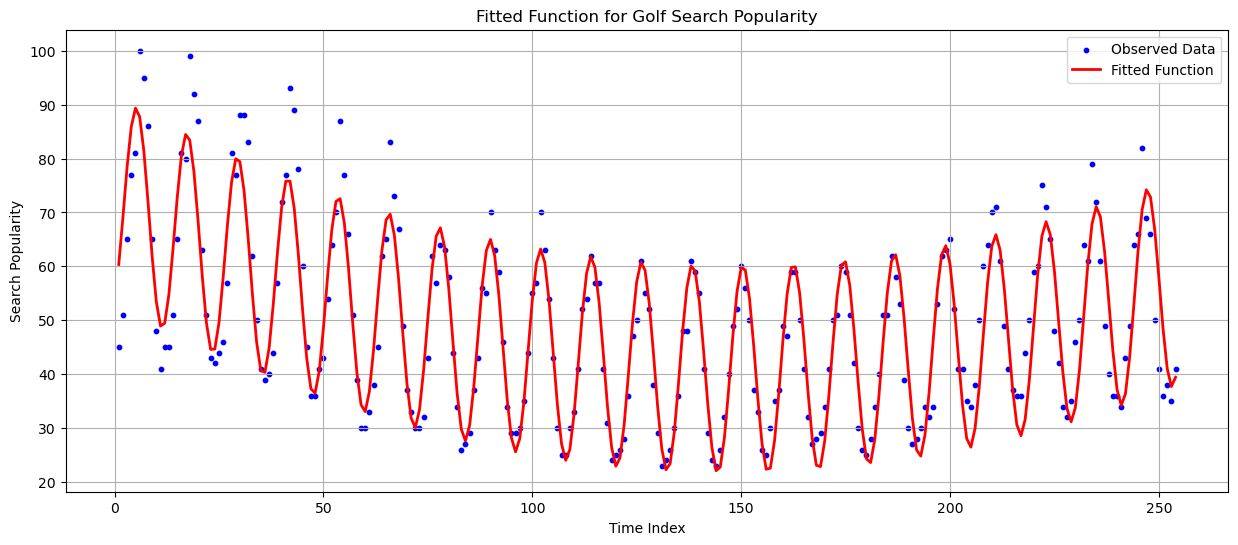

In [186]:
# Define the time index
n = len(y)
t = np.arange(1, n + 1)

# Generate basis functions: trend and seasonality
xcos = np.cos(2 * np.pi * f_est * t)
xsin = np.sin(2 * np.pi * f_est * t)
xt = t  # Linear trend
xt2 = t ** 2  # Quadratic trend

# Design matrix including trend and seasonal terms
X = np.column_stack([np.ones(n), xt, xt2, xcos, xsin])

# Fit OLS model
model = sm.OLS(y, X).fit()
beta_params = model.params  # Extract coefficients

# Generate fitted values
y_fit = X @ beta_params  # Compute fitted function

# Plot observed data and fitted function
plt.figure(figsize=(15, 6))
plt.scatter(t, y, label="Observed Data", color="blue", s=10)
plt.plot(t, y_fit, label="Fitted Function", color="red", linewidth=2)
plt.xlabel("Time Index")
plt.ylabel("Search Popularity")
plt.title("Fitted Function for Golf Search Popularity")
plt.legend()
plt.grid(True)
plt.show()

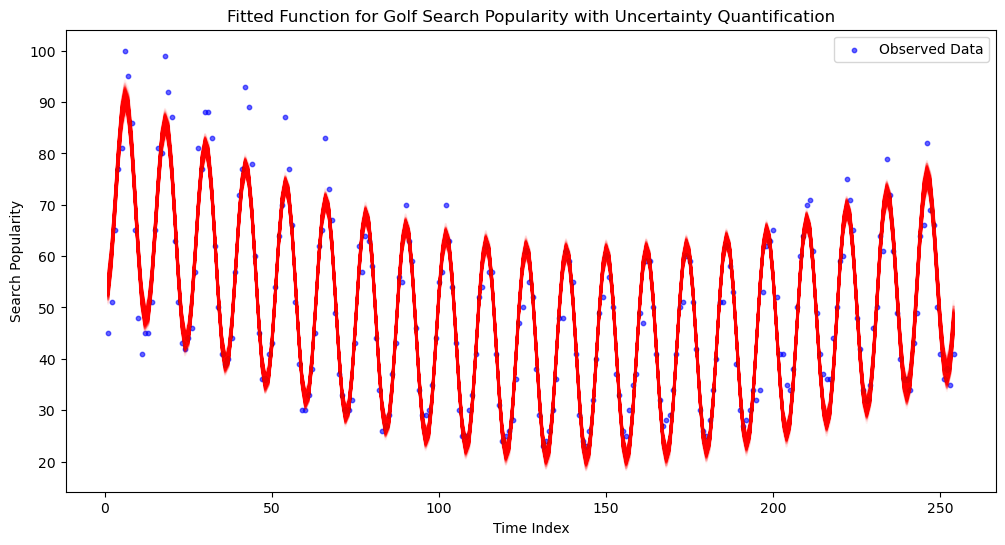

In [189]:
# Generate posterior samples
N = 1000
post_samples = posterior_sampling(N, y, best_f)

# Compute mean estimates from the posterior samples
mean_beta = np.mean(post_samples[:, :-1], axis=0)

# Generate fitted function based on posterior mean estimates
x = np.arange(1, len(y) + 1)
xcos = np.cos(2 * np.pi * best_f * x)
xsin = np.sin(2 * np.pi * best_f * x)
xt = x
xt2 = x ** 2

fitted_mean = (
    mean_beta[0] + mean_beta[1] * xt + mean_beta[2] * xt2 +
    mean_beta[3] * xcos + mean_beta[4] * xsin
)

# Plot observed data
plt.figure(figsize=(12, 6))
plt.scatter(x, y, color='blue', label="Observed Data", s=10, alpha=0.6)

# Plot multiple posterior samples
for i in range(1000):  # Plot 1000 samples for visibility
    beta_sample = post_samples[i, :-1]
    fitted_sample = (
        beta_sample[0] + beta_sample[1] * xt + beta_sample[2] * xt2 +
        beta_sample[3] * xcos + beta_sample[4] * xsin
    )
    plt.plot(x, fitted_sample, color='red', alpha=0.05)



# Labels and title
plt.xlabel("Time Index")
plt.ylabel("Search Popularity")
plt.title("Fitted Function for Golf Search Popularity with Uncertainty Quantification")
plt.legend()
plt.show()


In [190]:
# Summary of the posterior samples:
pd.DataFrame(post_samples).describe()

,0,1,2,3,4,5
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,73.191951,-0.440106,0.001494,-20.166220,-2.582214,5.050645
std,0.960481,0.016797,0.000064,0.448299,0.443558,0.230500
min,70.246583,-0.499958,0.001308,-21.972363,-3.999366,4.486200
25%,72.559600,-0.451141,0.001451,-20.453126,-2.866774,4.892094
50%,73.196815,-0.439274,0.001491,-20.150159,-2.569046,5.038666
75%,73.825711,-0.428980,0.001536,-19.885727,-2.316894,5.194832
max,76.020183,-0.388748,0.001711,-18.884727,-1.236481,5.829565


## Question 6c

The model effectively captures the seasonal periodicity present in the data. The fitted function aligns well with the observed data, particularly in the middle section, confirming that the quadratic trend and sinusoidal components are reasonable choices. However, the large model doesn't do well with capturing outliers or high-variance regions because the model assumes a smooth periodic pattern with a quadratic trend. Thus, if finer details or sudden shifts in search popularity need to be modeled a more flexible approach might be necessary.

## Question 7a

In [191]:
construction = pd.read_csv("TTLCONS.csv")
construction

,observation_date,TTLCONS
0,1993-01-01,458080
1,1993-02-01,462967
2,1993-03-01,458399
3,1993-04-01,469425
4,1993-05-01,468998
...,...,...
379,2024-08-01,2162132
380,2024-09-01,2142427
381,2024-10-01,2176627
382,2024-11-01,2180323


In [196]:
construction = pd.read_csv("TTLCONS.csv")

# Rename the column
construction.rename(columns={"TTLCONS": "spending"}, inplace=True)

# Convert observation_date to datetime format
construction['observation_date'] = pd.to_datetime(construction['observation_date'])

# Set observation_date as index for easier time series analysis
construction.set_index('observation_date', inplace=True)
# Create a time variable (months since first observation)
construction['t'] = np.arange(1, len(construction) + 1)

y= construction["spending"].values

# Display the first few rows
print(construction.head())

                  spending  t
observation_date             
1993-01-01          458080  1
1993-02-01          462967  2
1993-03-01          458399  3
1993-04-01          469425  4
1993-05-01          468998  5


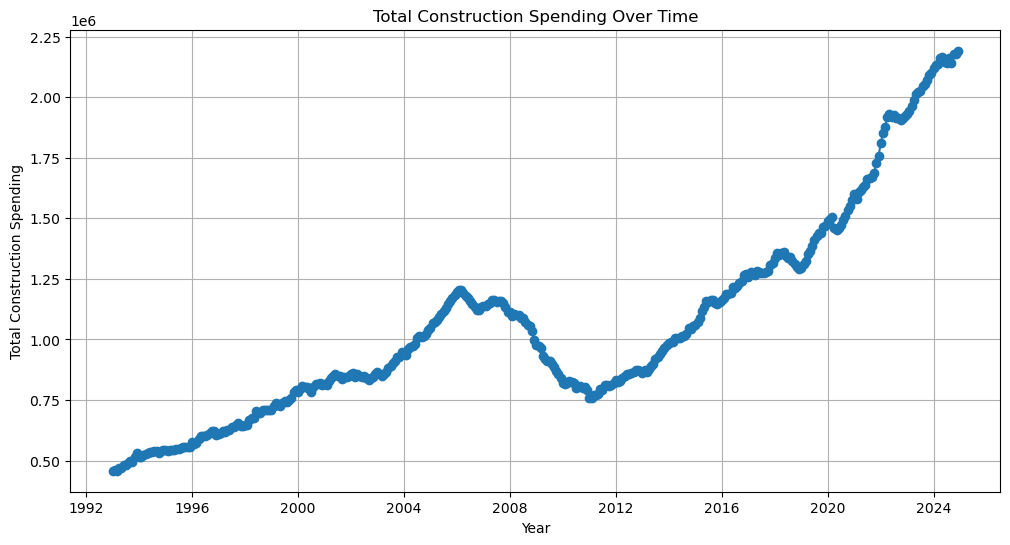

In [201]:
plt.figure(figsize=(12,6))
plt.plot(construction.index, y, marker='o', linestyle='-')
plt.xlabel("Year")
plt.ylabel("Total Construction Spending")
plt.title("Total Construction Spending Over Time")
plt.grid(True)
plt.show()

In [202]:
def rss(c):
    n = len(y)
    x = np.arange(1, n+1)
    X = np.column_stack([np.ones(n), x])
    if np.isscalar(c):
        c = [c]
    for j in range(len(c)):
        xc = ((x > c[j]).astype(float))*(x-c[j])
        X = np.column_stack([X, xc])
    md = sm.OLS(y, X).fit()
    ans = np.sum(md.resid ** 2)
    return ans

In [203]:
c1_gr = np.arange(1, n-1)
c2_gr = np.arange(1, n-1)
X, Y = np.meshgrid(c1_gr, c2_gr)
g = pd.DataFrame({'x': X.flatten(), 'y': Y.flatten()})
g['rss'] = g.apply(lambda row: rss([row['x'], row['y']]), axis = 1)

In [204]:
min_row = g.loc[g['rss'].idxmin()]
print(min_row)
c_opt = min_row[:-1]
print(c_opt)

x      1.750000e+02
y      2.250000e+02
rss    1.353677e+12
Name: 56622, dtype: float64
x    175.0
y    225.0
Name: 56622, dtype: float64


In [222]:
print("Point estimate for s1:", construction.index[174].strftime('%Y-%m-%d'))
print("Point estimate for s2:", construction.index[224].strftime('%Y-%m-%d'))

Point estimate for s1: 2007-07-01
Point estimate for s2: 2011-09-01


## Question 7b

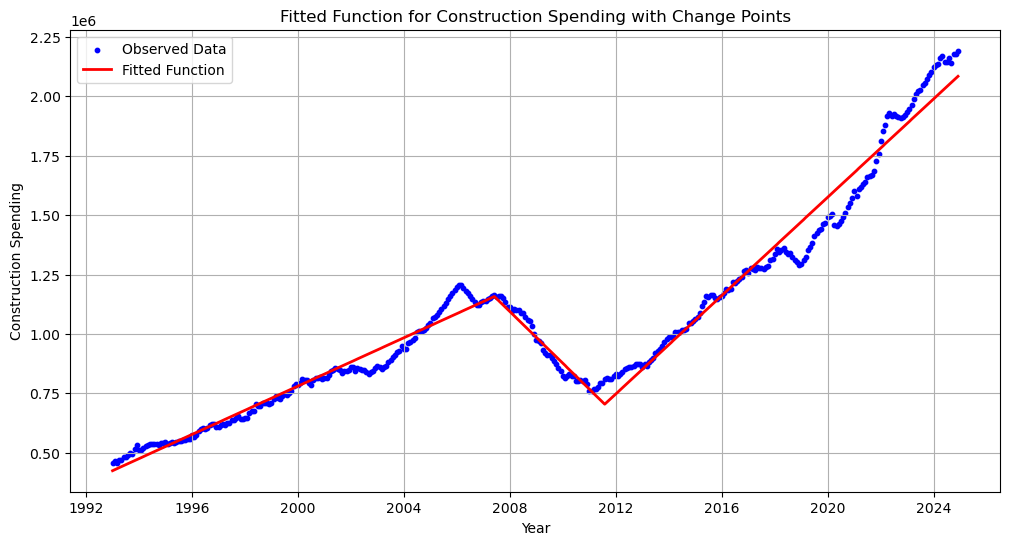

In [230]:
# Define change points (from previous estimate)
s1, s2 = 174, 224  # Corresponding to July 2007 and September 2011

# Define the time variable
t = construction['t'].values
y = construction['spending'].values

# Define basis functions for the piecewise model
X = np.column_stack([
    np.ones_like(t),    # Intercept
    t,                 # Linear term
    np.maximum(0, t - s1),  # Change point at s1
    np.maximum(0, t - s2)   # Change point at s2
])

# Fit OLS model
model = sm.OLS(y, X).fit()
beta_params = model.params  # Extract coefficients

# Generate fitted values
y_fit = X @ beta_params

# Plot observed data and fitted function
plt.figure(figsize=(12, 6))
plt.scatter(construction.index, y, color='blue', s=10, label="Observed Data")
plt.plot(construction.index, y_fit, color='red', linewidth=2, label="Fitted Function")
plt.xlabel("Year")
plt.ylabel("Construction Spending")
plt.title("Fitted Function for Construction Spending with Change Points")
plt.legend()
plt.grid(True)
plt.show()


## Question 7c

The first breakpoint (s1) around mid-2007 coincides with the onset of the subprime mortgage crisis, which led to a severe downturn in the housing market. The model reflect a decline in construction speanding allowing this period, aligning with the economic contraction and financial instability. The second breakpoint (s2) around 2011 corresponds to the period when construction spending began to recover, driven by government stimulus efforts and a gradual rebound in housing demand. The model captures this shift with an increase in the slope, indicating renewed growth in construction investment. In conclusion, the estimated breakpoints aligns with major economic events, making the model highly interpretable in an economic policy or forecasting context